In [21]:
import numpy as np
import pandas as pd
import string
import re
from IPython.core.display import HTML

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
from collections import defaultdict
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.cluster import KMeans


# cambiador de formatos para factorizar un dataset
from sklearn.feature_extraction.text import TfidfVectorizer 

# control de rendimiento
from time import time

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [22]:
ruta = 'Opiniones.csv'
data = pd.read_csv(ruta)
# print(data.head())

In [23]:
display(HTML(data.sample(20).to_html()))

,AÑO,SEDE,FACULTAD,CARRERA,OBSERVACIONES
52575,NaN,NaN,NaN,NaN,NaN
25932,2019.0,SEDE 1,FACULTAD 4,INGENIERIA 17,Los profes no ayudan
9573,2019.0,SEDE 1,FACULTAD 5,LICENCIATURA 22,Cafeteria mejor equipada
44820,2019.0,SEDE 8,FACULTAD 1,INGENIERIA 01,Proceso de Matrícula
2851,2019.0,SEDE 1,FACULTAD 2,INGENIERIA 08,.
13003,2019.0,SEDE 7,FACULTAD 3,INGENIERIA 15,El aire en el aula estuvo dañado todo el semestre.
5354,2019.0,SEDE 1,FACULTAD 2,INGENIERIA 07,Abran la cafeteria del ----
35595,2019.0,SEDE 1,FACULTAD 1,LICENCIATURA 01,"Mejorar los horarios de clase, que no sean tan tarde ya que a muchos se nos di----ulta la movilidad y más a esas altas horas"
34825,2019.0,SEDE 1,FACULTAD 2,INGENIERIA 12,Mejorar la seguridad en las paradas
36093,2019.0,SEDE 1,FACULTAD 2,LICENCIATURA 07,mejorar sus procesos de ayuda al estudiante y que los mismos dejen de ser extensos


In [24]:
data.rename(columns={'AÑO':'YEAR'}, inplace=True)
print(data.head())

     YEAR    SEDE    FACULTAD          CARRERA OBSERVACIONES
0  2019.0  SEDE 2  FACULTAD 1  LICENCIATURA 03             0
1  2019.0  SEDE 2  FACULTAD 1  LICENCIATURA 04             0
2  2019.0  SEDE 2  FACULTAD 2  LICENCIATURA 07             0
3  2019.0  SEDE 2  FACULTAD 3    INGENIERIA 15             0
4  2019.0  SEDE 3  FACULTAD 1  LICENCIATURA 04             0


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52583 entries, 0 to 52582
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YEAR           52519 non-null  float64
 1   SEDE           52519 non-null  object 
 2   FACULTAD       52519 non-null  object 
 3   CARRERA        52338 non-null  object 
 4   OBSERVACIONES  52340 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.0+ MB


In [28]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52160 entries, 0 to 52515
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YEAR           52160 non-null  float64
 1   SEDE           52160 non-null  object 
 2   FACULTAD       52160 non-null  object 
 3   CARRERA        52160 non-null  object 
 4   OBSERVACIONES  52160 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.4+ MB


In [29]:
data['YEAR'] = data['YEAR'].astype(float).astype(int)
col_list = ['YEAR','SEDE', 'FACULTAD', 'CARRERA']
for col in col_list:
    if col == 'TEXTO_TOKEN':
        data[col] = data[col].apply(lambda x: ' '.join(x))
    print(f'Columna {col}: {data[col].nunique()} subniveles')

Columna YEAR: 1 subniveles
Columna SEDE: 8 subniveles
Columna FACULTAD: 6 subniveles
Columna CARRERA: 103 subniveles


In [30]:
data.drop(columns='YEAR', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52160 entries, 0 to 52515
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SEDE           52160 non-null  object
 1   FACULTAD       52160 non-null  object
 2   CARRERA        52160 non-null  object
 3   OBSERVACIONES  52160 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB


In [31]:
display(HTML(data.sample(10).to_html()))

,SEDE,FACULTAD,CARRERA,OBSERVACIONES
14790,SEDE 1,FACULTAD 4,INGENIERIA 19,El wi fi es muy lento
4218,SEDE 7,FACULTAD 3,INGENIERIA 15,.
36881,SEDE 1,FACULTAD 5,INGENIERIA 25,mejores opciones de salon
41135,SEDE 1,FACULTAD 3,INGENIERIA 15,no hay mucho lugar para descansar entre largos recesos
27052,SEDE 4,FACULTAD 3,INGENIERIA 15,Mas capacidad para enviar los documentos en las plataformas
23590,SEDE 1,FACULTAD 2,INGENIERIA 12,"La universidad podría invertir en mejorar el hardware y la red del sistema para garantizar una conexión más rápida y estable. Esto podría incluir la actualización de enrutadores, puntos de acceso y ca"
44536,SEDE 1,FACULTAD 4,LICENCIATURA 15,Precio de maquina expendedora
19138,SEDE 1,FACULTAD 1,INGENIERIA 06,Ha
51222,SEDE 4,FACULTAD 1,LICENCIATURA 05,Variedad de Alimentos en la Cafetería
15496,SEDE 3,FACULTAD 1,LICENCIATURA 04,En


Acomodar para que quite stopwords

In [32]:
spanish_stopwords = list(stopwords.words('spanish'))
spanish_stopwords.extend(("xq", "oye", "dale", "dele", "ba", "abc", "nan", "na"))
print(spanish_stopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [34]:
def limpiar_tokenizar(texto):
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', texto)
    # Se convierte todo el texto a minúsculas
    nuevo_texto = nuevo_texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\
    \-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~—]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 2]
    # quitar los token que sean solamente de una letra repetidas 2 o mas veces
    nuevo_texto = [token for token in nuevo_texto if not re.fullmatch(r'(.)\1*', token)]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining zzzzz oooooo aaaaaaaa hhh eeeeeeee todo bien, bien"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining zzzzz oooooo aaaaaaaa hhh eeeeeeee todo bien, bien
['esto', 'ejemplo', 'limpieza', 'texto', 'cienciadedatos', 'textmining', 'todo', 'bien', 'bien']


In [35]:
def join_tokens(tokens):
    if isinstance(tokens, list):
        return ' '.join(tokens)
    else:
        return ''

In [54]:
display(HTML(data.sample(10).to_html()))

,SEDE,FACULTAD,CARRERA,OBSERVACIONES,TEXTO_TOKEN,TEXTO_STRING
24223,SEDE 6,FACULTAD 3,LICENCIATURA 10,Las construcción del pasillo principal que todavía no ha sido terminada,"[las, construcción, del, pasillo, principal, que, todavía, sido, terminada]",las construcción del pasillo principal que todavía sido terminada
38025,SEDE 2,FACULTAD 1,INGENIERIA 01,Nada,[nada],nada
14265,SEDE 1,FACULTAD 3,LICENCIATURA 08,El menú de la cafetería debe ser más variado aunque su precio aumente un poco,"[menú, cafetería, debe, ser, más, variado, aunque, precio, aumente, poco]",menú cafetería debe ser más variado aunque precio aumente poco
9477,SEDE 1,FACULTAD 3,LICENCIATURA 11,Cafetería con un horario más extenso.,"[cafetería, con, horario, más, extenso]",cafetería con horario más extenso
21324,SEDE 8,FACULTAD 1,POSTGRADO 17,Internet,[internet],internet
24480,SEDE 2,FACULTAD 1,LICENCIATURA 05,Las puertas de algunos baños no funcionan,"[las, puertas, algunos, baños, funcionan]",las puertas algunos baños funcionan
43215,SEDE 5,FACULTAD 2,TÉCNICO 05,Pague laboratorio y no los use.,"[pague, laboratorio, los, use]",pague laboratorio los use
14297,SEDE 2,FACULTAD 3,INGENIERIA 15,El menú estudiantil debe ser más variado,"[menú, estudiantil, debe, ser, más, variado]",menú estudiantil debe ser más variado
12295,SEDE 1,FACULTAD 3,LICENCIATURA 11,Decir,[decir],decir
4400,SEDE 8,FACULTAD 5,LICENCIATURA 23,.,[],


In [36]:
data['OBSERVACIONES'] = data['OBSERVACIONES'].astype(str)
data['TEXTO_TOKEN'] = data['OBSERVACIONES'].apply(lambda x: limpiar_tokenizar(x))

# Concatenar la lista de tokens en una sola cadena con espacios
data['TEXTO_STRING'] = data['TEXTO_TOKEN'].apply(join_tokens)

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
)
t0 = time()
X_tfidf = vectorizer.fit_transform(data['TEXTO_STRING'])

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.595 s
n_samples: 52160, n_features: 3065


In [37]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.001


In [38]:
X_tfidf

<52160x3065 sparse matrix of type '<class 'numpy.float64'>'
	with 216567 stored elements in Compressed Sparse Row format>

In [39]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(X_tfidf)  # X es tu matriz de datos
    silhouette_avg = silhouette_score(X_tfidf, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Encontrar el número óptimo de clusters basado en el método de la silueta
optimal_n_clusters = np.argmax(silhouette_scores) + 2  # +2 porque empezamos desde n_clusters=2

print(f"Número óptimo de clusters según el método de la silueta: {optimal_n_clusters}")

Número óptimo de clusters según el método de la silueta: 13


In [42]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=optimal_n_clusters,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()


Number of elements asigned to each cluster: [  246  2328   532   928 37477  2082   821  1186    29  2007  2704   192
  1628]
Number of elements asigned to each cluster: [  152 39916  1725   148   379  1240   218  2243   926  1048  2022   821
  1322]
Number of elements asigned to each cluster: [  636 38838   268  2871   821   200   382  1154  1839  1352   926  2265
   608]
Number of elements asigned to each cluster: [ 2650  3254 38318   630   134  1309  1392   616   146   656   598   176
  2281]
Number of elements asigned to each cluster: [   24   907 41093   618  2232  1375  1147   766   653   478   323  1884
   660]



In [45]:
kmeans = KMeans(
    n_clusters=optimal_n_clusters,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf.toarray(), name="KMeans\non tf-idf vectors")

clustering done in 26.72 ± 1.09 s 
Silhouette Coefficient: 0.109 ± 0.008
Davies-Bouldin Index: 2.695 ± 0.115
Calinski-Harabasz Index: 601.418 ± 53.684


In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 2.865 s
Explained variance of the SVD step: 49.5%


In [47]:
kmeans = KMeans(
    n_clusters=optimal_n_clusters,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.36 ± 0.12 s 
Silhouette Coefficient: 0.126 ± 0.011
Davies-Bouldin Index: 2.438 ± 0.110
Calinski-Harabasz Index: 1065.884 ± 140.536


In [49]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=optimal_n_clusters,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.11 ± 0.05 s 
Silhouette Coefficient: 0.134 ± 0.009
Davies-Bouldin Index: 2.484 ± 0.034
Calinski-Harabasz Index: 1073.539 ± 91.649


In [50]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(optimal_n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: proyectores los algunos salones funcionan que aulas las cables problemas 
Cluster 1: que para más hay con una por los mas estudiantes 
Cluster 2: wifi mejorar más bien todo nada estacionamientos ninguna mas cafeteria 
Cluster 3: los estudiantes baños para estacionamientos que mejorar salones con más 
Cluster 4: las cafeterías que aulas para mejorar los clases más computadoras 
Cluster 5: precios cafetería los cafeteria altos comida muy alimentos variedad bajar 
Cluster 6: internet mejorar del lento mejor calidad velocidad muy señal mejora 
Cluster 7: servicio fotocopiado mejorar internet fotocopias que buen fotocopia mejor wifi 
Cluster 8: cafetería variedad comida más menú alimentos mejorar los precio que 
Cluster 9: laboratorios los equipos para mejorar computadoras que más las informática 
Cluster 10: instalaciones las mejorar seguridad del dentro los calidad que universidad 
Cluster 11: matrícula sistema plataforma virtual proceso mejorar página que pago por 
Cluster 12:

In [62]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words=None, n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(data['TEXTO_STRING'])
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 6.433 s


In [63]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.30 ± 0.09 s 
Silhouette Coefficient: 0.123 ± 0.005
Davies-Bouldin Index: 2.444 ± 0.162
Calinski-Harabasz Index: 1018.692 ± 50.633


In [64]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering done in 0.17 ± 0.07 s 
Silhouette Coefficient: 0.133 ± 0.004
Davies-Bouldin Index: 2.442 ± 0.078
Calinski-Harabasz Index: 1074.321 ± 37.137


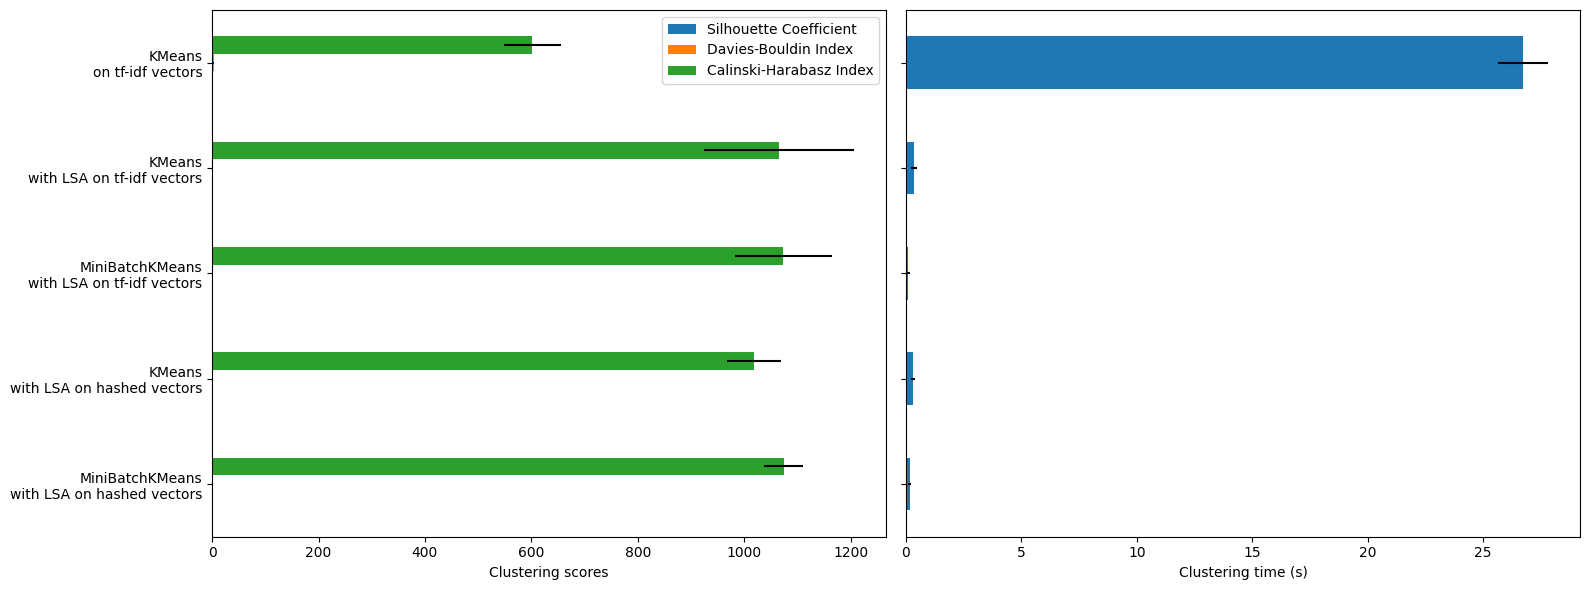

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

Cambiar a que muestra los temas de kmean con LSA on hashed vectors

In [66]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(optimal_n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: falta aires los proyectores acondicionados mejoras internet excelente muy por 
Cluster 1: internet todo para que servicio los laboratorio salones estudio instalaciones 
Cluster 2: internet cafeteria mejor todo mas falta bien para fotocopiadora lento 
Cluster 3: los internet bien para hay estudiantes que universidad ninguno biblioteca 
Cluster 4: salones que internet los aire bien baños lento estudio clases 
Cluster 5: biblioteca servicio muy mejora cafeteria comida menú fotocopiado virtual lento 
Cluster 6: wifi mejorar internet los cafetería estacionamientos del para más que 
Cluster 7: ninguna tengo observación internet queja otra tener todo momento mas 
Cluster 8: bien todo nada cafetería estacionamientos internet los más que mas 
Cluster 9: mejor tengo las internet más comida calidad wifi del instalaciones 
Cluster 10: laboratorios internet satisfecho los más equipos todo estoy las seguridad 
Cluster 11: satisfecho hay los internet muy estoy mas que todo seguridad 
Clust